# Cell Images for Detecting Malaria

Human malaria is a serious disease caused by protozoan parasites belonging to the genus Plasmodium. Despite their complex life cycle, the entire pathology of the disease is caused by infection by an asexual parasite in the bloodstream. When a person is bitten by an Anopheles mosquito, sporozoite forms are injected. Once within the liver, they infiltrate hepatocytes and expand into exoerythrocytic merozoite forms, which are then discharged into the circulatory system as shown in Figure 1 (Cowman, Berry and Baum, 2012). This project uses a publicly available dataset collected by Kaggle, which contains microscopic images of human blood cells labelled as either infected or uninfected with the malaria parasite. The purpose of this work is to apply deep learning techniques, specifically pre-trained convolutional neural network (CNN) model, to automatically detect whether a given cell image is infected with malaria. By utilising the power of deep learning, the project seeks to achieve accurate and efficient classification, reducing the need for manual analysis by medical professionals.


![Figure 1](./JCB_201206112_Fig1.jpg)

[Figure 1 ]



In the study conducted by Sriporn et al. (2020), several deep learning models were used for verification and analysis, including Xception, Inception-V3, ResNet-50, NasNetMobile, VGG-16 and AlexNet. These models demonstrated strong performance in medical image classification. However, many of them are computationally heavy and require significant processing power and memory. In contrast, this study adopts MobileNetV2 as the baseline model due to its lightweight architecture and faster inference speed. MobileNetV2 which reduce the number of parameters and computational cost without significantly decreasing accuracy. Compared to models such as VGG-16 and even EfficientNetB0, which were tested and found to involve more parameters and longer training times, MobileNetV2 proved to be more efficient, making it more suitable for rapid deployment.

## Exploratory data analysis

In [1]:
import os

#Accessing the images from the folder (path file)
parasitized_dir = '/Users/kpitsiakkos/Desktop/cell_images/Parasitized'
uninfected_dir = '/Users/kpitsiakkos/Desktop/cell_images/Uninfected'

#Counting the number of images in each folder 

print(f"Parasitized: {len(os.listdir(parasitized_dir))}")
print(f"Uninfected: {len(os.listdir(uninfected_dir))}")



Parasitized: 13780
Uninfected: 13780


## Visual inspection

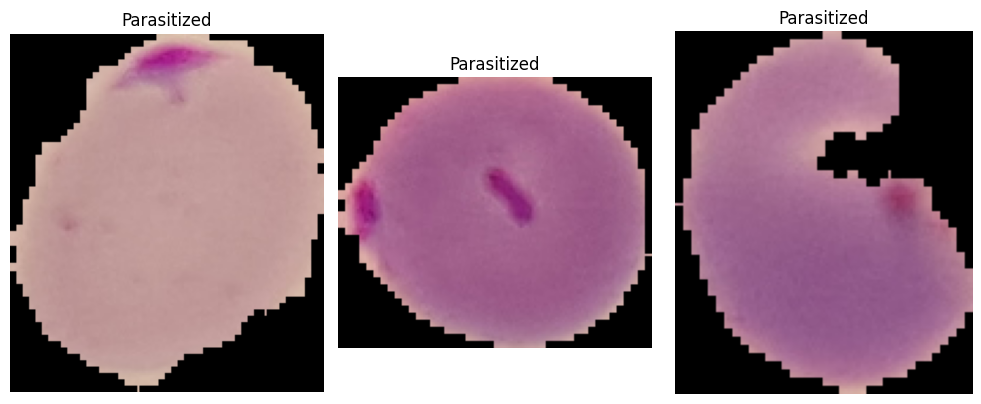

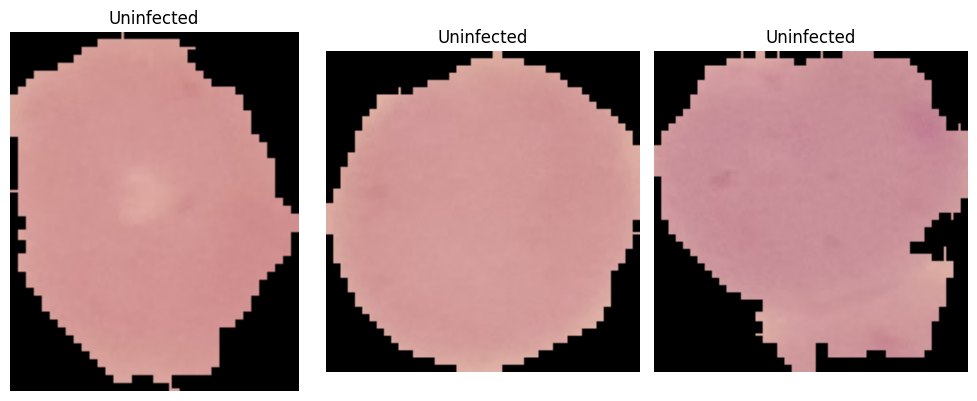

In [2]:
import matplotlib.pyplot as plt
import cv2
import random

#Display 'n' (3 random images) from the folder with the leabel.
def plot_random_images(folder, label, n=3):

    #List the Images from the default folder and select random samples.
    images = os.listdir(folder)
    sample_images = random.sample(images, n)

    #Set the 'figsize' (figure size) to 10 width and 4 height.
    plt.figure(figsize=(10, 4))

    #Create a loop for the selected images.
    for i, img in enumerate(sample_images):
        img_path = os.path.join(folder, img)

        #Read the image using OpenCV and Convert from BGR format to RGB Format
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #Plot the images
        plt.subplot(1, n, i+1)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')
        
    #Adjust the layout
    plt.tight_layout()
    plt.show()

plot_random_images(parasitized_dir, 'Parasitized')
plot_random_images(uninfected_dir, 'Uninfected')


The provided code defines and executes a function that randomly displays a set of images from a specified folder, typically used for visual inspection of datasets in image classification tasks. Using the plot_random_images function, the code selects 'n' random images (the default is 3) from a given folder, labeled either as "Parasitized" or "Uninfected" to represent images of malaria-infected or healthy cells. It uses the 'os' and 'random' libraries to retrieve and sample image filenames and 'cv2' (OpenCV) to read the images. Since OpenCV loads the images in BGR format, it converts them to RGB for proper visualisation with matplotlib.pyplot. The function then plots the selected images side by side using plt.subplot() within a fixed 10x4 inch format size and adds titles based on the provided label.

### Check shape and the size of the images

In [17]:
#Create an empty list to store the images shapes
shapes = []

#Loop the first 100 images in the parasitized directory.
for img in os.listdir(parasitized_dir)[:100]:
    img_path = os.path.join(parasitized_dir, img)

    #Read the images using OpenCV.
    image = cv2.imread(img_path)

    #Check if the image was read successfully if not, print a warning message with the image filename.
    if image is not None:
        shapes.append(image.shape)
    else:
        print(f"Warning: Could not read image {img}")


This code breaks down the dimensions of the first 100 images in the Parasitized dataset. It initialises an empty list called shapes to store the shape of each image. Using a loop, it reads each image with OpenCV (cv2.imread). If an image is successfully read, its shape is added to the list. Otherwise, a warning message is printed showing the filename of the unreadable image. This helps to understand the variation in image sizes before preprocessing.

# Preprocessing

In [ ]:
IMG_SIZE = 128
def load_and_preprocess_image(file_path):
    image = cv2.imread(file_path)
    #Resize the image to 128x128
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image


This code defines a function called load_and_preprocess_image which takes a file path for an image, reads the image using OpenCV, resizes it to 128×128 pixels as defined by IMG_SIZE, and normalises the pixel values by dividing them by 255.0 to scale them between 0 and 1. This preprocessing step ensures that all input images are of consistent size and shape, which is necessary for feeding them into a deep learning model.

### Read images from defferent angles

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#ImafeDataGenarator with some specified augmentation parameters
datagen = ImageDataGenerator(
    #Randomly rotate images up to 20 degrees
    rotation_range=20,
    #Zoom randomly up to 15%
    zoom_range=0.15,
    #Shift image horizontally up to 10%
    width_shift_range=0.1,
    #Shift the image vertically up to 10%
    height_shift_range=0.1,
    horizontal_flip=True,
    #Fill new pixels with the nearest pixel value
    fill_mode="nearest"
)

2025-05-03 12:46:51.023516: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


This code initialises an ImageDataGenerator from TensorFlow Keras, which is used to augment the data in real-time during model training. It applies a variety of random transformations to the training images, including rotation up to 20 degrees, zooming up to 15%, shifting the width and height by 10%, and flipping the images horizontally. Fill_mode="nearest" ensures that any new pixels inserted during these transformations are filled based on the nearest pixel values. This augmentation technique helps improve the generalisability and robustness of the model by exposing it to varying versions of the training data.

In [6]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def load_images(parasitized_dir, uninfected_dir, img_size=128, limit=None):
    def is_image_file(filename):
        return filename.lower().endswith(('.png', '.jpg', '.jpeg'))

    X, y = [], []

    # Load Parasitized images (label = 1)
    parasitized = [f for f in os.listdir(parasitized_dir) if is_image_file(f)]
    if limit:
        parasitized = parasitized[:limit]
    for img_name in tqdm(parasitized, desc="Loading Parasitized"):
        path = os.path.join(parasitized_dir, img_name)
        img = cv2.imread(path)
        if img is None:
            print(f"Could not read {path}")
            continue
        try:
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(1)
        except Exception as e:
            print(f"Error processing {path}: {e}")

    # Load Uninfected images (label = 0)
    uninfected = [f for f in os.listdir(uninfected_dir) if is_image_file(f)]
    if limit:
        uninfected = uninfected[:limit]
    for img_name in tqdm(uninfected, desc="Loading Uninfected"):
        path = os.path.join(uninfected_dir, img_name)
        img = cv2.imread(path)
        if img is None:
            print(f"Could not read {path}")
            continue
        try:
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(0)
        except Exception as e:
            print(f"Error processing {path}: {e}")

    # Final arrays
    X = np.array(X, dtype='float32') / 255.0
    y = np.array(y)

    print(f"\n Done! Loaded {len(X)} images "
          f"({np.sum(y==1)} Parasitized, {np.sum(y==0)} Uninfected)")
    return X, y


parasitized_dir = '/Users/kpitsiakkos/Desktop/cell_images/Parasitized'
uninfected_dir = '/Users/kpitsiakkos/Desktop/cell_images/Uninfected'
X, y = load_images(parasitized_dir, uninfected_dir, img_size=128, limit=None)


Loading Uninfected: 100%|██████████| 13779/13779 [00:36<00:00, 381.99it/s]



 Done! Loaded 27558 images (13779 Parasitized, 13779 Uninfected)


This code defines and uses a function called load_images to load and preprocess malaria cell images from two folders, one containing parasitized cells and the other containing uninfected cells. It reads each image using OpenCV, resizes them to 128×128 pixels and normalizes the pixel values to a range of 0-1. Labels are assigned as 1 for parasitized and 0 for uninfected images. It uses tqdm to display a progress bar during loading and includes error handling for unreadable files. Finally, it returns the image data 'x' and corresponding labels 'y' as NumPy tables, ready for training a deep learning model.

## Spit the Dataset into Training and Test sets

In [ ]:
from sklearn.model_selection import train_test_split

#split data into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

#Split temp into validation (20%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp)

#Print shapes
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Training set: (19290, 128, 128, 3) (19290,)
Validation set: (5539, 128, 128, 3) (5539,)
Test set: (2729, 128, 128, 3) (2729,)


This code uses train_test_split from Scikit-learn to split the dataset into training, validation and test sets. First, it splits the data into 70% training data and 30% temporary data. Then, it further splits the temporary data into 20% validation sets and 10% test sets. The stratify parameter ensures that the class distribution remains balanced across all splits and the final split patterns are printed for validation.

# Implementation of MobileNetV2 Pre-Trained Model

![MobileNetV2 Architecture](The-architecture-of-the-MobileNetV2-with-a-sample-input-image-and-19-residual-bottleneck.png)

[Figure 2: MobileNetV2 Architecture] (Shahoveisi et al., 2023)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


# Load pre-trained MobileNetV2 (exclude top layer)
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
#Freeze all layers of base model
base_model.trainable = False 

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
# Binary classification
output = Dense(1, activation='sigmoid')(x) 

# Create the full model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of architecture
model.summary()



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

The MobileNetV2 model used in this study is a lightweight and computationally efficient convolutional neural network architecture. It utilises a unique structure consisting of residual congestion blocks, which are clearly depicted in the architectural diagram of the model. These blocks combine 1x1 convolutions with depth-separated convolutions, significantly reducing the number of parameters and computational requirements compared to traditional convolutional layers while maintaining competitive accuracy (Nguyen, H., 2020). 

The Conv2D layers serve as initial and intermediate convolution operations that extract spatial features from the image, with the first layer processing the input resizing (128x128x3). Within each congestion block, the DepthwiseConv2D layers are used to apply a single filter per input channel, against standard convolutions that blend all channels making them highly efficient and central to the lightweight model design. The model also incorporates BatchNormalization layers to stabilise and accelerate training by normalising the output of convolutions, which helps reduce the risk of overfitting. Activation modes play an important role in the performance of MobileNetV2. It uses ReLU6, a  variant of the standard ReLU activation function, which improves numerical stability and hardware efficiency by limiting outputs to a maximum of 6. In addition, residual connections implemented through Add layers allow better gradient flow across the network, which is particularly beneficial in training deep architectures (Hua et al., 2022). Towards the end of the model, a GlobalAveragePooling2D layer is used to reduce each feature map to a single value, allowing the network to be more spatially invariant and eliminating the need for large dense layers. Dense layers then provide the decision logic, one with 128 units that uses ReLU for feature subtraction and a final dense output layer with a sigmoidal activation function that performs binary classification (healthy or infected). Interrupt layers are also included to randomly deactivate a portion of the neurons during training, increasing robustness and reducing overfitting (J, Mageswari and A, 2025), (Xiang et al., 2019). 

In terms of parameters, the model is highly efficient. It contains about 2.42 million total parameters, with only 164,097 parameters being trainable - these correspond to the custom upper layers that were added. The remaining 2.26 million parameters come from the frozen base of MobileNetV2, which was pre-trained on ImageNet. This design ensures fast training times, reduced memory usage and suitability for deployment on resource constrained devices, making MobileNetV2 an ideal choice for medical image analysis tasks such as malaria detection.


# Train the CNN model

In [9]:

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 299s 471ms/step - accuracy: 0.8570 - loss: 0.3329 - val_accuracy: 0.9245 - val_loss: 0.1974
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 291s 483ms/step - accuracy: 0.9162 - loss: 0.2201 - val_accuracy: 0.9310 - val_loss: 0.1796
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 274s 455ms/step - accuracy: 0.9222 - loss: 0.2031 - val_accuracy: 0.9251 - val_loss: 0.1896
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 267s 443ms/step - accuracy: 0.9233 - loss: 0.1931 - val_accuracy: 0.9314 - val_loss: 0.1799
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 475s 789ms/step - accuracy: 0.9228 - loss: 0.2001 - val_accuracy: 0.9251 - val_loss: 0.2001
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2351s 4s/step - accuracy: 0.9266 - loss: 0.1897 - val_accuracy: 0.9330 - val_loss: 0.1761
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 279s 463ms/step - accuracy: 0.9301 - loss: 0.1786 - val_accuracy: 0.9363 - val_loss: 0.1682
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 282s 467ms/step - accuracy: 0.9335 - l

The code using model.fit() trains the model for 10 epochs with a batch size of 32, using the training set for learning and the validation set for performance monitoring after each epoch. The output shows the training results for 10 epochs. From the first epoch, the model starts with a validation accuracy of 92.45% and steadily improves across epochs, reaching a peak validation accuracy of 93.68% in epoch 8. At the same time, the validation loss decreases smoothly, reaching 0.1634 by epoch 9, indicating better generalisation and lower error. These results highlight the effectiveness of MobileNetV2 in quickly learning useful features even with relatively few trainable parameters, while maintaining high accuracy and low overfitting.

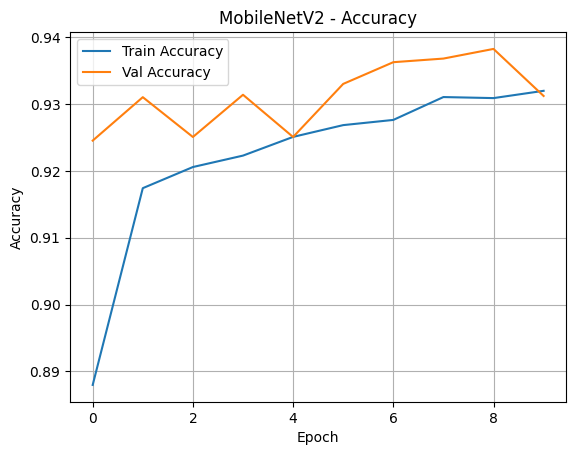

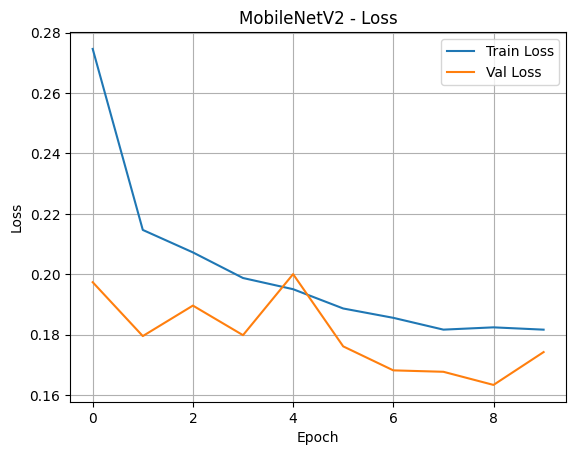

In [ ]:
#Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('MobileNetV2 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('MobileNetV2 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


The graphs show the accuracy and loss of training and validation over the epochs using the training history of the MobileNetV2 model. The top graph shows that both training and validation accuracy are growing continuously, with validation accuracy peaking at around 93.8%, indicating strong generalisation. The bottom graph shows that the loss decreases steadily for both the training and validation sets, with the validation loss stabilising around 0.16. These visual results confirm that the model learns efficiently without signs of overfitting.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

#Load MobileNetV2 base model (without the top classification layers)
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Initially freeze all layers

#Build the new model on top of MobileNetV2
inputs = Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

#Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

#Train the top classifier layers first
history = model.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)

#unfreeze some of the deeper layers for fine-tuning
base_model.trainable = True

#Freeze all but last 30 layers for stability
for layer in base_model.layers[:-30]:
    layer.trainable = False

#Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

#Fine-tune the full model
fine_tune_history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

#Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 211s 341ms/step - accuracy: 0.8520 - loss: 0.3521 - val_accuracy: 0.9244 - val_loss: 0.2113
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 182s 302ms/step - accuracy: 0.9095 - loss: 0.2265 - val_accuracy: 0.9175 - val_loss: 0.2208
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 180s 298ms/step - accuracy: 0.9182 - loss: 0.2135 - val_accuracy: 0.9260 - val_loss: 0.1862
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 191s 317ms/step - accuracy: 0.9205 - loss: 0.2030 - val_accuracy: 0.9216 - val_loss: 0.2064
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 199s 329ms/step - accuracy: 0.9237 - loss: 0.2021 - val_accuracy: 0.9318 - val_loss: 0.1779
Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 260s 410ms/step - accuracy: 0.8464 - loss: 0.4829 - val_accuracy: 0.9381 - val_loss: 0.1720
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 226s 375ms/step - accuracy: 0.9359 - loss: 0.1863 - val_accuracy: 0.9431 - val_loss: 0.1644
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 231s 383ms/step - accuracy: 0.9414 - loss

The above code implements a two-phase training approach using the MobileNetV2 architecture for binary image classification. In the first phase, the model is built by loading MobileNetV2 without the top classification layers and freezing all layers. This prevents the pre-trained weights from changing during initial training. Next, a new classifier head is added, which consists of the global average concentration for leveling feature maps, two dropout layers to reduce overfitting, a dense layer with 128 activated ReLU units for feature learning, and a final activated sigmoid unit for binary classification. The model is trained with the Adam optimizer and a moderate learning rate (0.001) and trained for 5 epochs on the new dataset. Early stopping is used to avoid overfitting by stopping training if the validation performance stops improving. During this phase, the model achieved validation accuracy of up to 93%, showing strong performance from retraining only the top layers. In the second phase, the detailed setting is introduced. The previously frozen base model is made trainable again, but only the last 30 layers are actually set to trainable. This strategy maintains the generic low level features learned in ImageNet and only adjusts the more general, high level features that are task specific. The model is recompiled at a much lower learning rate (1e-5), allowing fine adjustments without distorting the pre-trained weights. This phase is trained for up to 10 epochs, again using early stopping.

The training results shown above  demonstrate steady improvement. After fine tuning, the model achieved 97,37% training accuracy, 95.6% validation accuracy, and 95.68% final test accuracy, with a low loss value of 0.1592. These results confirm that fine tuning significantly improves the generalisation ability of the model by improving the feature extraction process of the core network.

The use of both training phases is optional. The first phase ensures fast and safe convergence using pretrained knowledge and the second phase allows the model to be specialised for the target task.


# Evaluation and Comparison 

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

#Predict class probabilities on the test set
y_pred_probs = model.predict(X_test)

#Convert probabilities to binary class labels (threshold = 0.5)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

#Display the classification report
print("\n" + "="*50)
print("Classification Report")
print("="*50)
print(classification_report(y_test, y_pred_labels, target_names=["Uninfected", "Parasitized"]))


86/86 ━━━━━━━━━━━━━━━━━━━━ 22s 252ms/step

Classification Report
              precision    recall  f1-score   support

  Uninfected       0.94      0.97      0.96      1365
 Parasitized       0.97      0.94      0.96      1364

    accuracy                           0.96      2729
   macro avg       0.96      0.96      0.96      2729
weighted avg       0.96      0.96      0.96      2729



The code evaluates the trained MobileNetV2 model using classification metrics. It first predicts the class probabilities for the test set and then converts them to binary labels using a value threshold of 0.5. It then prints a classification report that includes accuracy, recall, F1-score and support for each class.

The result shows excellent model performance with an overall accuracy of 96%. Both classes Uninfected and Parasitized have high accuracy and recall 0.94 and 0.97, indicating that the model is highly effective in correctly identifying both infected and uninfected cells.

Confusion Matrix:
[[1325   40]
 [  78 1286]]

AUC Score: 0.9903


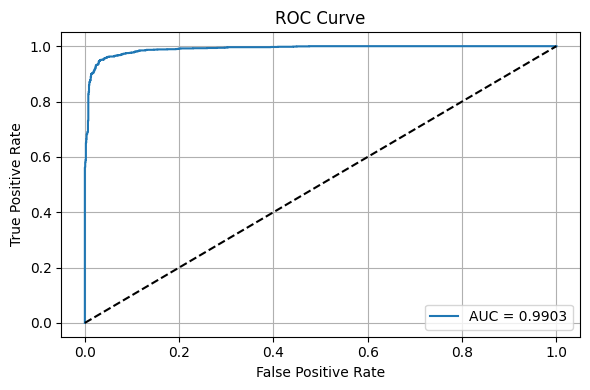

In [ ]:
# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_labels))

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
auc_score = roc_auc_score(y_test, y_pred_probs)

print("\n" + "="*40)
print(f"AUC Score: {auc_score:.4f}")
print("="*40)

# Optional: Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

This code evaluates the performance of a trained MobileNetV2 model using a confusion matrix and the ROC (Receiver Operating Characteristic) curve along with the AUC (Area Under the Curve) score. These metrics are necessary to understand how well the model distinguishes between two classes,  parasitized and uninfected cells.

The confusion matrix provides a summary of the model predictions compared to the actual labels. The output of the 1325 true negatives which orrectly predicted uninfected, 40 false positives of uninfected predicted as parasitized,  78 false negatives of parasitized predicted as uninfected, and  1286 true positives which correctly predicted parasitized.

The AUC score, calculated using the roc_auc_score, is 0.9903, which is excellent. The closer the score is to 1.0, the better the model discriminates between the two classes. An AUC above 0.99 reflects near perfect classification.

The ROC curve, depicted by the percentages of true positives and false positives, visually confirms the high performance of the model. The curve rises steeply towards the upper left corner, showing that the model achieves high rates of true positives while maintaining low rates of false positives.

# References :



Cowman, A.F., Berry, D. and Baum, J. (2012). The cellular and molecular basis for malaria parasite invasion of the human red blood cell. The Journal of Cell Biology, 198(6), pp.961–971. doi:https://doi.org/10.1083/jcb.201206112.

Nguyen, H., 2020. Fast object detection framework based on mobilenetv2 architecture and enhanced feature pyramid. J. Theor. Appl. Inf. Technol, 98(05), pp.812-824.

Hua, Y., Yu, C.-H., Zhao, Q., Li, M.-G., Wu, W.-T. and Wu, P. (2022). Surrogate modeling of heat transfers of nanofluids in absorbent tubes with fins based on deep convolutional neural network. International Journal of Heat and Mass Transfer, 202, pp.123736–123736. doi:https://doi.org/10.1016/j.ijheatmasstransfer.2022.123736.

J, J., Mageswari, P.U. and A, A. (2025). Deep Learning-Based Transfer Learning with MobileNetV2 for Crop Disease Detection. 2025 International Conference on Intelligent and Innovative Technologies in Computing, Electrical and Electronics (IITCEE), pp.1–9. doi:https://doi.org/10.1109/iitcee64140.2025.10915399.

Sriporn, K., Tsai, C.-F., Tsai, C.-E. and Wang, P. (2020). Analyzing Malaria Disease Using Effective Deep Learning Approach. Diagnostics, 10(10), p.744. doi:https://doi.org/10.3390/diagnostics10100744.

Shahoveisi, F., Taheri Gorji, H., Shahabi, S., Hosseinirad, S., Markell, S. and Vasefi, F. (2023). Application of image processing and transfer learning for the detection of rust disease. Scientific Reports, 13(1). doi:https://doi.org/10.1038/s41598-023-31942-9.

Xiang, Q., Wang, X., Li, R., Zhang, G., Lai, J. and Hu, Q. (2019). Fruit Image Classification Based on MobileNetV2 with Transfer Learning Technique. Proceedings of the 3rd International Conference on Computer Science and Application Engineering  - CSAE 2019. doi:https://doi.org/10.1145/3331453.3361658.